<a href="https://colab.research.google.com/github/vigkrishna/Tweets-Emotion-Recognition-With-Tensorflow/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.1


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install datasets

In [4]:
from datasets import load_dataset
ds = load_dataset("dair-ai/emotion", "split")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train = ds['train']
val = ds['validation']
test = ds['test']

In [7]:
train

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
def get_tweets(x):
  tweets = [x['text'] for x in x]
  labels = [x['label'] for x in x]

  return tweets, labels

In [9]:
tweets,labels=get_tweets(train)

In [10]:
tweets[0]

'i didnt feel humiliated'

In [11]:
labels[0]

0

In [12]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

In [13]:
import numpy as np
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

**labels -> 0: sadness, 1: joy, 2: love, 3: angry, 4: fear, 5: surprise**

## Task 4: Tokenizer

1. Tokenizing the tweets

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenised = Tokenizer(num_words = 10000, oov_token ='<UNK>') #NUM_WORDS -> TOTAL NUMBER OF WORDS TO BE STORED IN VOCAB
#OOV -> OUT-OF-VOCABULARY TOKEN, I.E, IF ANY WORD IS NOT IN VOCAB THEN REPLACE IT WITH UNK -> UNKNOWN


In [16]:
tokenised.fit_on_texts(tweets)

**To check what actually tokenisation did**

In [17]:
tweets[0]

'i didnt feel humiliated'

In [18]:
tokenised.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

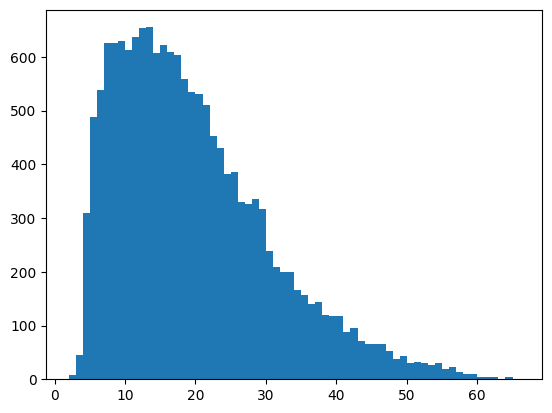

In [19]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [20]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(tokenised.texts_to_sequences(tweets), maxlen=maxlen, padding='post', truncating='post')

In [21]:
padded

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

In [22]:
len(padded[0])

50

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels (already implemented and labels are numerical)

In [23]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


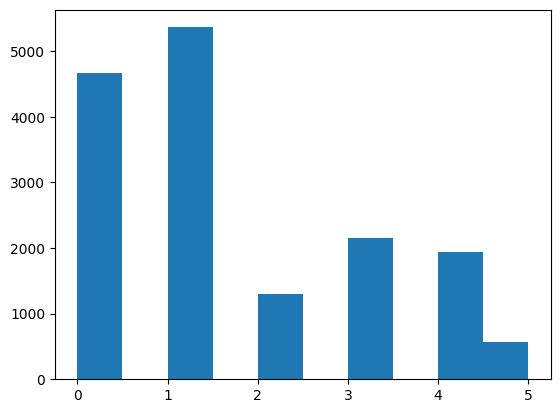

In [24]:
plt.hist(labels)
plt.show()

In [25]:
print(labels[0])

0


0->sadness (dataset is having labels in numerical format)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.build(input_shape=(None, maxlen))

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [30]:
val_tweets, val_labels = get_tweets(val)

val_sequences = tokenised.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_sequences, maxlen=maxlen, padding='post', truncating='post')

In [31]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [32]:
h = model.fit(
    padded, np.array(labels),
    validation_data=(val_padded, np.array(val_labels)),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3874 - loss: 1.5271 - val_accuracy: 0.6530 - val_loss: 0.9299
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6875 - loss: 0.8073 - val_accuracy: 0.7270 - val_loss: 0.7383
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8069 - loss: 0.4949 - val_accuracy: 0.8410 - val_loss: 0.4937
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9061 - loss: 0.2860 - val_accuracy: 0.8650 - val_loss: 0.4383
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9375 - loss: 0.2080 - val_accuracy: 0.8765 - val_loss: 0.4161
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9599 - loss: 0.1389 - val_accuracy: 0.8845 - val_loss: 0.3720
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9689 - loss: 0.1004 - val_accuracy: 0.8975 - val_loss: 0.3425
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9708 - loss: 0.0948 - val

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

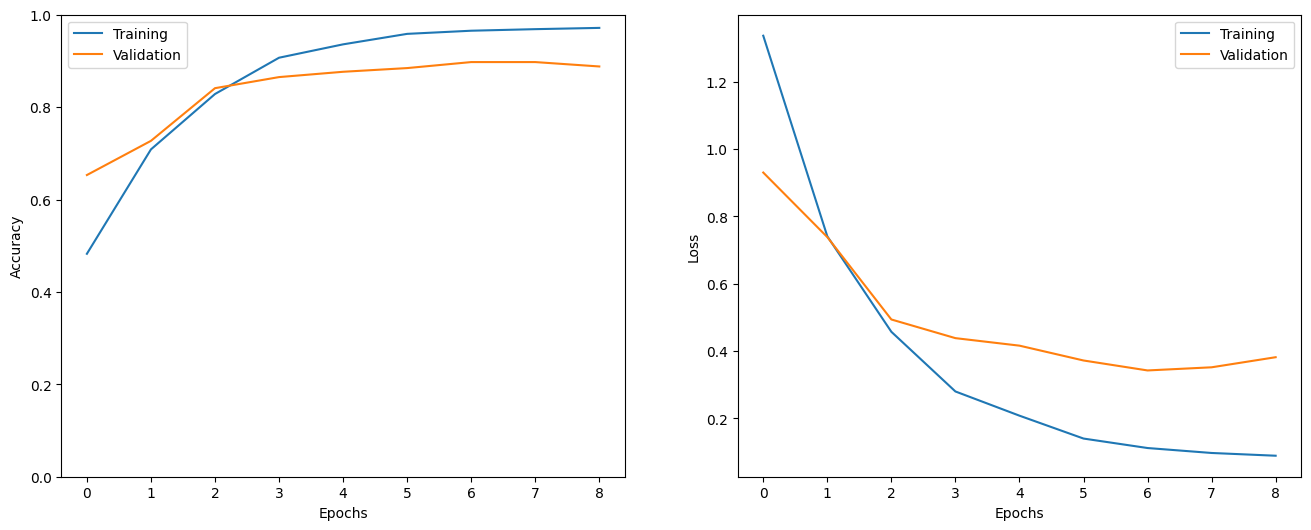

In [33]:
show_history(h)

In [34]:
test_tweets,test_labels = get_tweets(test)

In [35]:
test_sequences = tokenised.texts_to_sequences(test_tweets)
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

In [36]:
_ = model.evaluate(test_padded, np.array(test_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9133 - loss: 0.2773


In [37]:
i = random.randint(0, len(test_tweets) - 1)

print('Sentence: ',test_tweets[i])
print('emotion linked with sentence: ',test_labels[i])

p = (np.expand_dims(test_sequences[i], axis=0))
predictions = model.predict(p)
pred=np.argmax(predictions,axis=1)[0]
print('Predicted emotion: ',pred)

Sentence:  i was feeling brave i would try to pick up running again
emotion linked with sentence:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
Predicted emotion:  1
